<a href="https://colab.research.google.com/github/enzoampil/BertSum/blob/master/experiments/jumper_jumps_analysis_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip -q install pydub

In [0]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3, fp='audio.wav'):
    """
    Record audio, save file, and return in playable state
    """
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open(fp,'wb') as f:
        f.write(b)
    print("Audio saved in {}".format(fp))
    audio = AudioSegment.from_file(BytesIO(b))
    return audio

# Record

Listening to the audio actually indicates that there are 2 types of signals for each jump (in order):

1. Swoosh of the jump rope
2. Feet landing on the ground

Each **jump** corresponds to the two steps above

In [8]:
record(sec=60, fp="100_jumps.wav")

<IPython.core.display.Javascript object>

Audio saved in 100_jumps.wav


## Save file to GCS

In [0]:
from google.colab import auth

In [0]:
auth.authenticate_user()

In [11]:
!gsutil cp 100_jumps.wav gs://jumper_app/audio_samples/100_jumps.wav

Copying file://100_jumps.wav [Content-Type=audio/x-wav]...
/ [1 files][380.7 KiB/380.7 KiB]                                                
Operation completed over 1 objects/380.7 KiB.                                    


# Get model from GCS if already saved

In [12]:
!gsutil cp gs://jumper_app/audio_samples/100_jumps.wav .

Copying gs://jumper_app/audio_samples/100_jumps.wav...
/ [1 files][380.7 KiB/380.7 KiB]                                                
Operation completed over 1 objects/380.7 KiB.                                    


# Jumps EDA

EDA based on this [resource](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)

In [13]:
!pip install librosa

In [0]:
import librosa

In [0]:
audio_data = '100_jumps.wav'
SAMPLE_SECONDS = 10

In [32]:
x , sr = librosa.load(audio_data)
# We sample based on the first sample seconds
x = x[: 22000 * SAMPLE_SECONDS]
print(type(x), type(sr))#<class 'numpy.ndarray'> <class 'int'>print(x.shape, sr)#(94316,) 22050


<class 'numpy.ndarray'> <class 'int'>


In [33]:
librosa.load(audio_data, sr=44100)

(array([ 0.        ,  0.        ,  0.        , ..., -0.00772523,
        -0.02029181, -0.02102212], dtype=float32), 44100)

In [39]:
# First 10 seconds should have about 19 jumps
import IPython.display as ipd
ipd.Audio(audio_data)

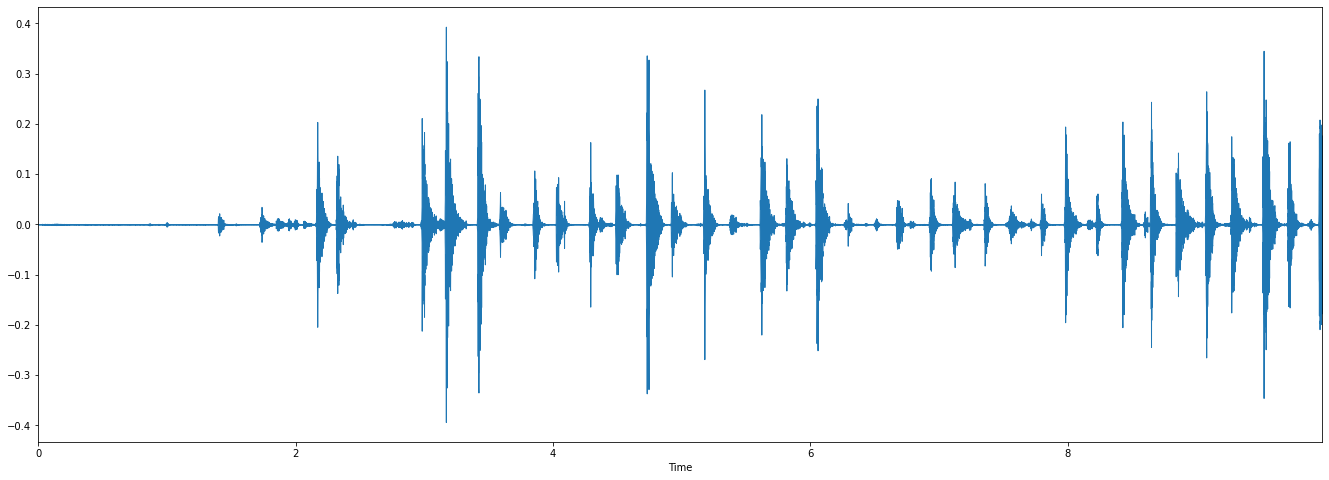

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(23, 8))
librosa.display.waveplot(x, sr=sr)

In [41]:
# 22 kHz
print('total:', x.shape[0])
print('per minute:', x.shape[0] / 60)

total: 220000
per minute: 3666.6666666666665


### Spectogram

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

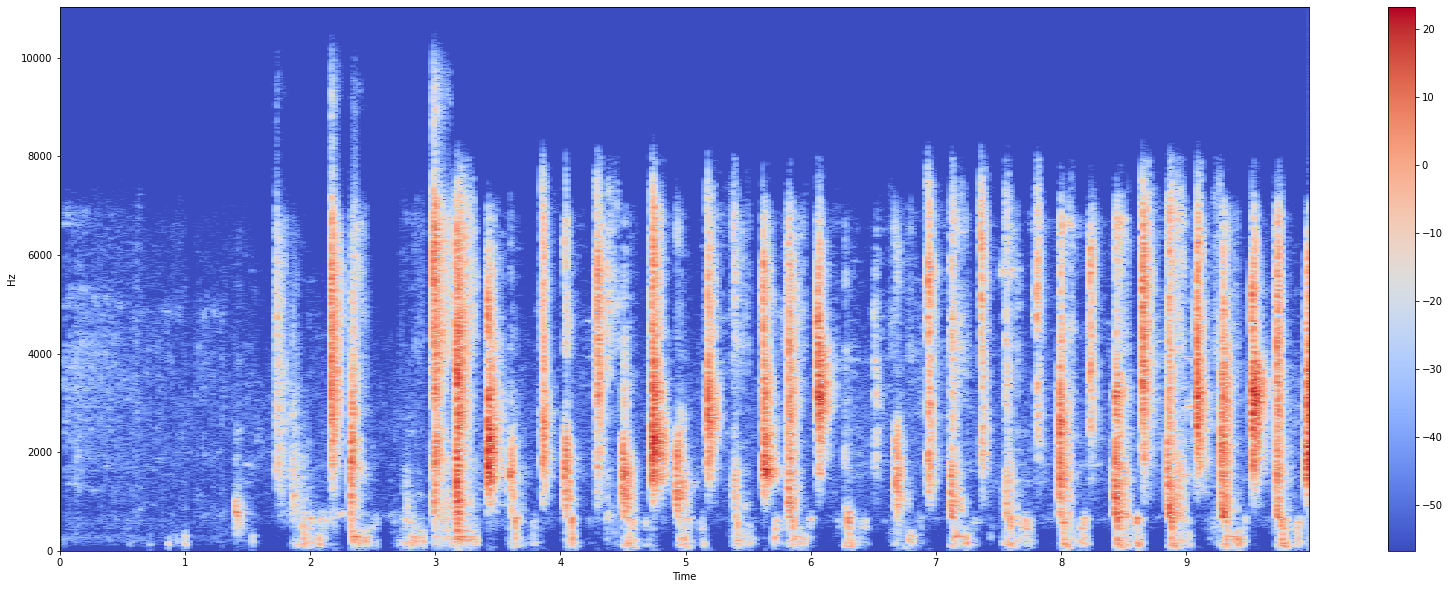

In [43]:
# Spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(28, 10))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [46]:
X.shape, X.reshape(-1).shape

((1025, 430), (440750,))

## Feature extraction

### Spectral Centroid

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located.

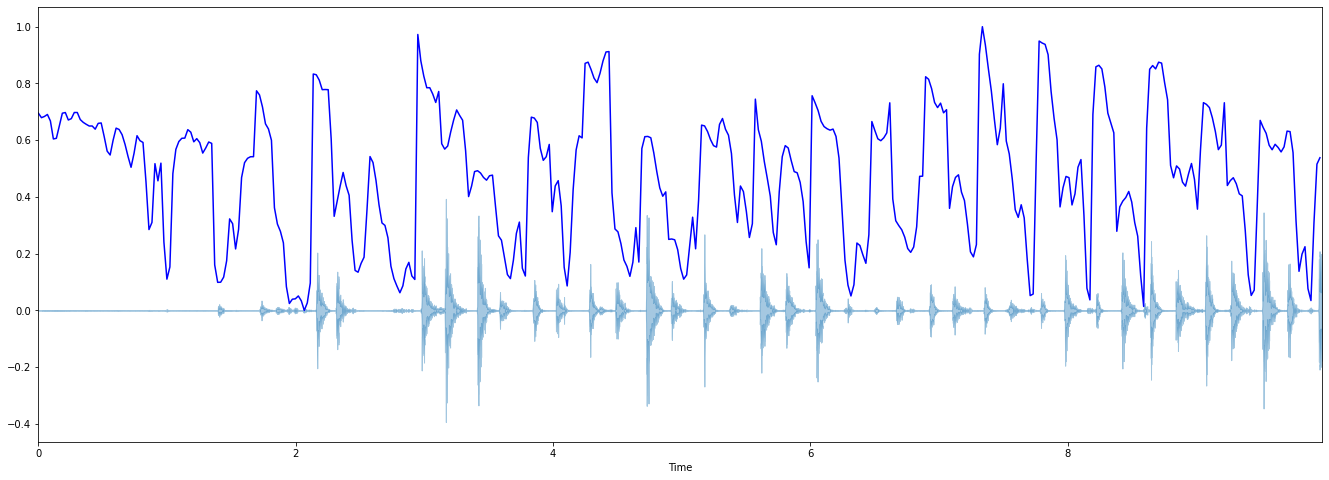

In [55]:
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
plt.figure(figsize=(23, 8))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

## Spectral Rolloff

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

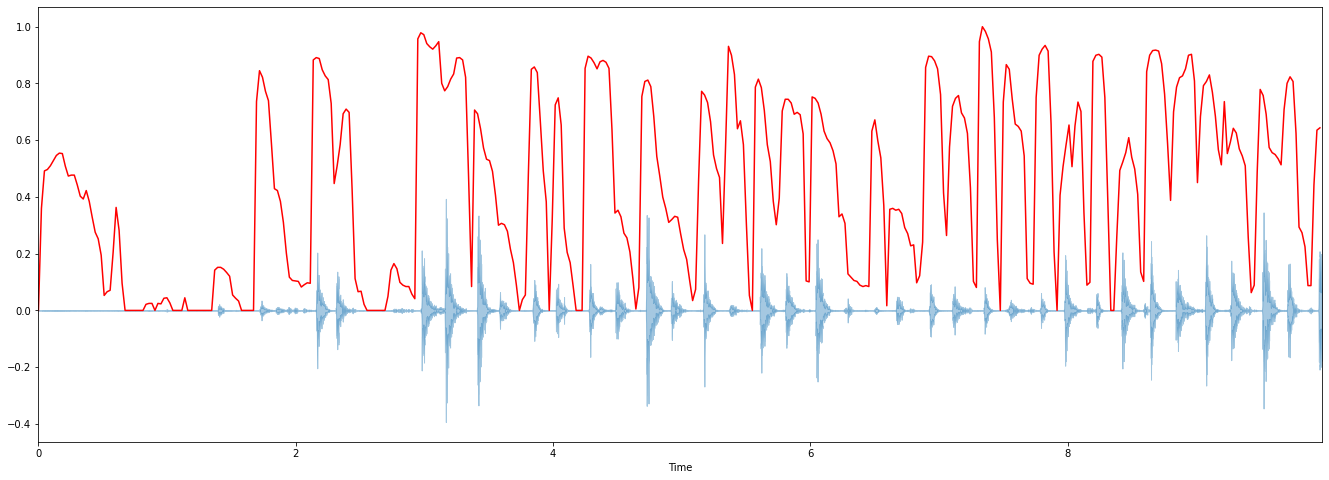

In [58]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(23, 8))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

### Spectral Bandwidth

The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

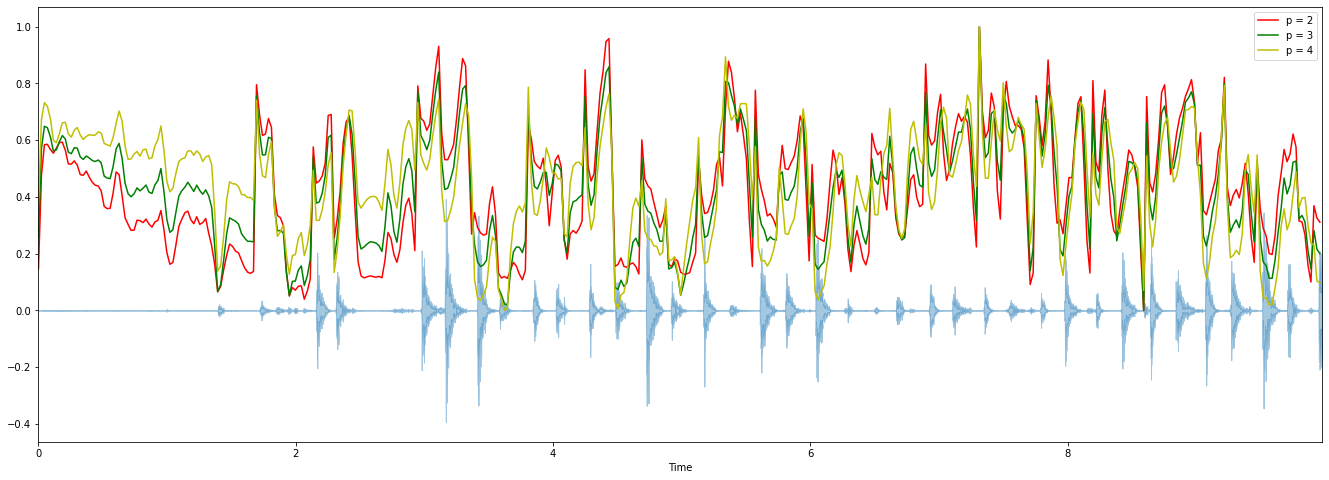

In [68]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(23, 8))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

### Zero-Crossing Rate

A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.# New Section

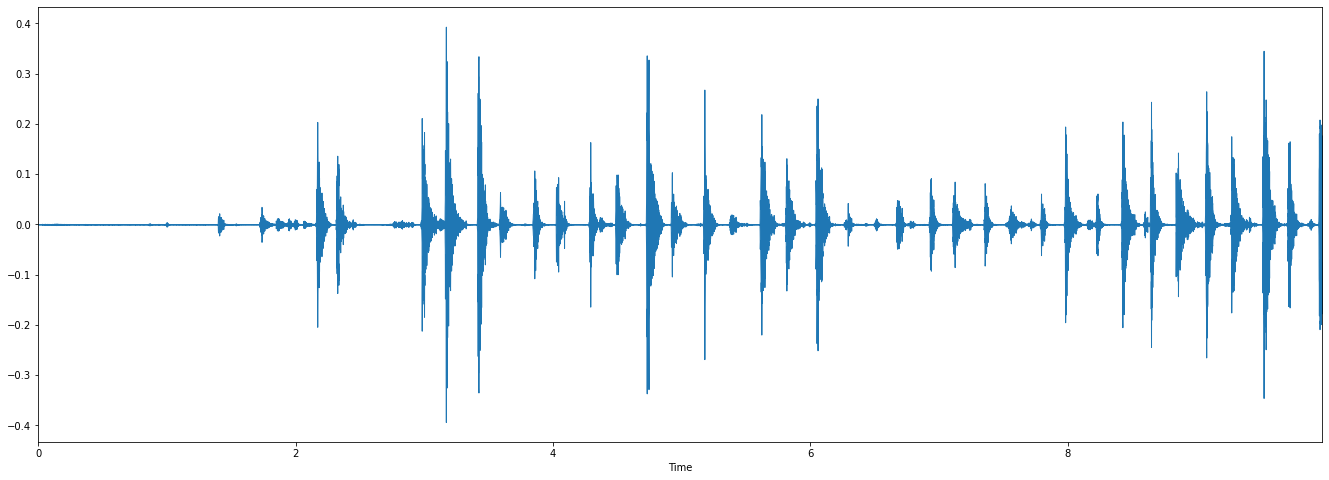

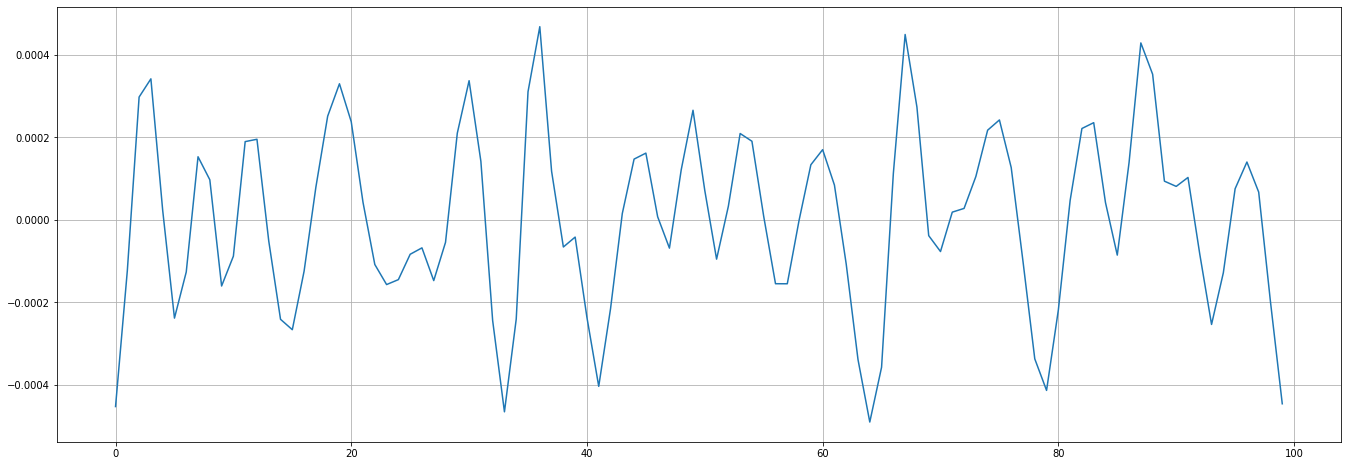

In [69]:
x, sr = librosa.load(audio_data)
x = x[: SAMPLE_SECONDS * 22000]
#Plot the signal:
plt.figure(figsize=(23, 8))
librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(23, 8))
plt.plot(x[n0:n1])
plt.grid()

In [70]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))#16

30


### Mel-Frequency Cepstral Coefficients(MFCCs)

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

(20, 430)


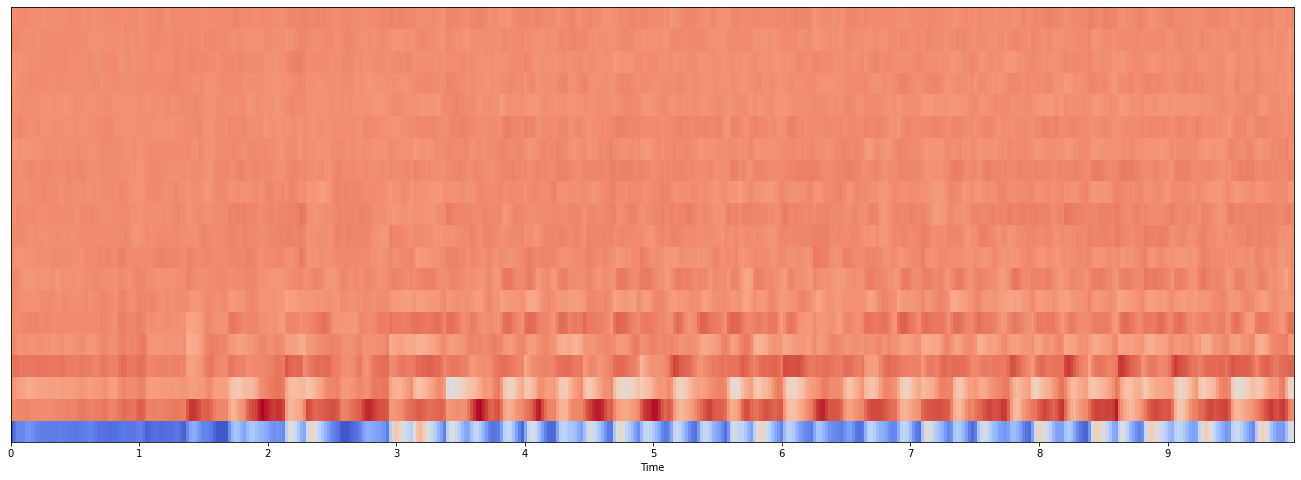

In [79]:
mfccs = librosa.feature.mfcc(x)#, sr=fs)
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(23, 8))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Chroma feature

A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, It provides a robust way to describe a similarity measure between music pieces.

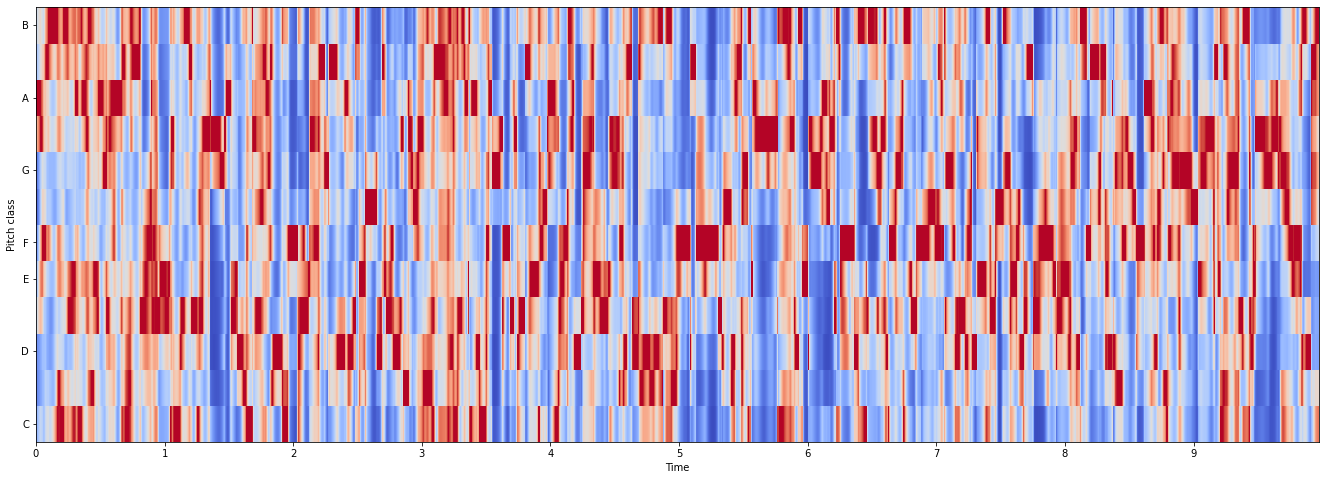

In [80]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=5)
plt.figure(figsize=(23, 8))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=5, cmap='coolwarm')